# Задание 4. Распознавание образов, описываемых бинарными признаками

## Написать код, реализующий алгоритм распознавания бинарных образов символов, соответствующих первым буквам фамилии и имени исполнителя: E S

### 0. Библиотеки и вспомогательные методы

In [107]:
import numpy as np
import math
from scipy.stats import binom
import matplotlib.pyplot as plt

In [108]:
def draw_letter(letter, title):
    plt.imshow(letter)
    plt.suptitle(title)
    plt.show()

### 1. Задание исходных данных

In [109]:
alphabet=np.zeros([35, 26])
#буква E
alphabet[:,4]=[1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1]
#буква S
alphabet[:,18]=[0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0]

In [110]:
###[alphabet,targets]=prprob;%загрузка бинарных стандартных изображений букв 
n=35 #количество признаков (исходя из размера изображений)
M=2 #количество классов
s=np.zeros([n,2]) #эталонные описания
s[:,0]=alphabet[:,4] #буква E 
s[:,1]=alphabet[:,18] #буква S
pw=[0.3,0.7] #априорные вероятности гипотез
N=20 #количество шагов изменения варьируемого параметра - pi
K=1000 #количество реализаций
ns=np.sum(abs(s[:,0]-s[:,1])) #общее количество несовпадающих элементов
s_=1-s #получение инвертированных изображений
pi=np.zeros(N)
[p12th, p21th, p12ex, p21ex]=[np.array(pi), np.array(pi), np.array(pi), np.array(pi)]
Pc_=np.zeros([N,2,2]) #экспериментальная матрица вероятностей ошибок

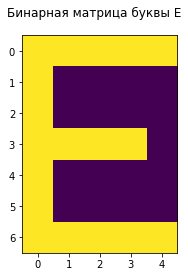

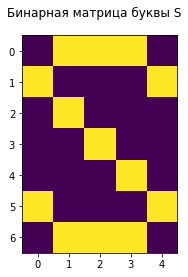

In [111]:
draw_letter(np.reshape(s[:,0], (7, 5)), 'Бинарная матрица буквы E')
draw_letter(np.reshape(s[:,1], (7, 5)), 'Бинарная матрица буквы S')

In [112]:
#Цикл по значениям вероятности искажения элементов символов
for i in range(N):
    pi[i]=(1/N)*i #вероятность искажения элемента (пикселя)

### 2. Синтез решающего правила и расчет теоретических вероятностей ошибок

In [113]:
#регуляризация разделяющей функции
for i in range(N):
    pI=pi[i]
    if pI==0:
        pI=0.0001
    if pI==0.5:
        pI=0.4999
    pI_=1-pI
    G1=np.zeros(n)
    G2=np.zeros(n)
    #вычисление коэффициентов разделяющей функции
    for k in range(n):
        G1[k]=np.log((s[k,0]*pI_+s_[k,0]*pI)/(s[k,1]*pI_+s_[k,1]*pI))
        G2[k]=np.log((s[k,0]*pI+s_[k,0]*pI_)/(s[k,1]*pI+s_[k,1]*pI_))
    l0_=np.log(pw[1]/pw[0]) #порог принятия решения
    L0=np.log(pw[1]/pw[0])/(2*np.log(pI_)-2*np.log(pI))+ns/2
    L0r=math.floor(L0)
    #расчет вероятностей ошибок 
    if pI<0.5:
        p12th[i]=binom.cdf(L0r,ns,pI_)
        p21th[i]=1-binom.cdf(L0r,ns,pI)
    else:
        p12th[i]=1-binom.cdf(L0r,ns,pI_)
        p21th[i]=binom.cdf(L0r,ns,pI)
    #косяк: p12th и p21th всегда зависят от (L0r,ns,pI_), а это константы.
    #соответсвенно, в p12th и p21th все числа одинаковые. у сироты-разные 

### 3.Тестирование алгоритма методом статистических испытаний

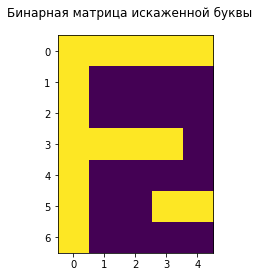

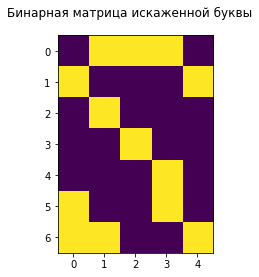

In [114]:
for i in range(N):
    for k in range(K): #цикл по числу реализаций
        for m in range(M): #цикл по классам
            x=s[:,m]
            r=np.random.rand(n)
            ir=[]
            for j in range(len(r)):
                if r[j]<pI:
                    ir.append(j)
            #инверсия в точках, в которых вероятность искажения меньше, чем pI (0.95)
            for j in range(len(ir)):
                x[j]=1-x[j]            
            #возврат в начальное состояние всех точек. 
            #искаженные ранее точки примут исходное состояние. 
            #неискаженые ранее, станут искажеными. 
            #в итоге искаженых точек получится мало, в среднем-5% (все, у кого r>=0.95)
            x_=np.array(x)
            for j in range(len(x)):
                x_[j]=1-x[j]
            u=np.dot(G1,x)+np.dot(G2,x_)-l0_ #вычисление значения разделяющих функций
            if u>0:
                iai=0
            else: 
                iai=1
            Pc_[i,m,iai]=Pc_[i,m,iai]+1 #фиксация результата распознавания
            #отображение примеров искажения символов (вариаций искажения очень много, мы рисуем только одну из них)
            if ((k==0) and (i==1)):
                draw_letter(np.reshape(x_,(7,5)), 'Бинарная матрица искаженной буквы')
    Pc_[i,:,:]=Pc_[i,:,:]/K
    p12ex[i]=Pc_[i,0,1]
    p21ex[i]=Pc_[i,1,0]

### 4.Визуализация результата в виде графиков вероятностей ошибок

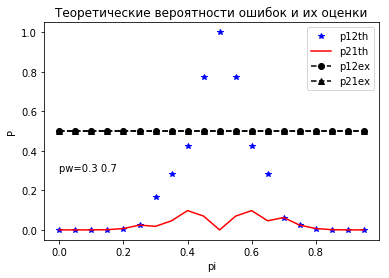

In [115]:
plt.plot(pi,p12th,'b*', label='p12th')
plt.plot(pi,p21th,'-r', label='p21th')
plt.plot(pi,p12ex,'--ok', label='p12ex')
plt.plot(pi,p21ex,'--^k', label='p21ex')
plt.title('Теоретические вероятности ошибок и их оценки')
plt.xlabel('pi')
plt.ylabel('P')
plt.text(0, 0.3, 'pw='+''.join(str(i)+' ' for i in pw))
plt.legend(bbox_to_anchor=(1, 1), labels=['p12th', 'p21th', 'p12ex', 'p21ex'])
plt.show()